First of all I want to thank @jerzydziewierz for the interesting challenge.
In this notebook I'm trying to address 2 questions: selection of the most efficient model, and if the model learning to recognize insects of flowers. <br>
I'm selecting between 4 models, using Tensorflow generators for image delivery and augmentations. There is also Test Time Augmentations applied to see how efficient it can be in this case. <br>
I created a supplemental dataset consisiting of 370 images of just flowers to verify the bias of the model.

# Import libraries

In [1]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

import cv2
import os
import math
from math import ceil, floor, log

# to be used to get better performance
# from sklearn.model_selection import KFold
!pip install -q efficientnet
import efficientnet.tfkeras as efn

import scikitplot as skplt

print("TF version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
TF version: 2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preparations
Initialize hyperparameters

In [2]:
N_epochs = 30
SEED = 1970
N_TTA = 5
# in the version 9 of the botebook I made images size = 300 for all models
MODELS = {
          'ResNet50':[tf.keras.applications.ResNet50,32,300],
          'DenseNet121':[tf.keras.applications.DenseNet121,32,300],
          'EfficientNetB3':[efn.EfficientNetB3,8,300],
          'EfficientNetB6':[efn.EfficientNetB6,8,300]
         }
path = '../input/'
path_org = 'bee-vs-wasp/kaggle_bee_vs_wasp/' #path to the main dataset
path_flowers = 'flowers-blossom/' # path to 370 images of just flowers
df = pd.read_csv(path + path_org + "labels.csv")
df_flowers = pd.read_csv(path + path_flowers + "flowers.csv")
df.head(5)

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


Creating all dataframes

In [3]:
# transorm path column so we will get valid full path to the images
df['path'] = df.path.apply(lambda x: x.replace('\\', '/') )
df['path'] = df.path.apply(lambda x: path_org + x )

df_flowers['path'] = df_flowers.path.apply(lambda x: x.replace('\\', '/') )
df_flowers['path'] = df_flowers.path.apply(lambda x: path_flowers + x )

# generate file lists and labels
labels_cols = ['is_bee', 'is_wasp', 'is_otherinsect', 'is_other']
df_train = df.loc[(df.is_validation == 0) & (df.is_final_validation == 0)]
df_valid = df.loc[(df.is_validation == 1)]
df_test = df.loc[(df.is_final_validation == 1)]

df_test_ext = pd.concat([df_test, df_flowers])

y_train = df_train.loc[:,['id']+labels_cols]
y_train.set_index('id', inplace = True)
y_valid = df_valid.loc[:,['id']+labels_cols]
y_valid.set_index('id', inplace = True)
y_test = df_test.loc[:,['id']+labels_cols]
y_test.set_index('id', inplace = True)
y_test_ext = df_test_ext.loc[:,['id']+labels_cols]
y_test_ext.set_index('id', inplace = True)

df_train.head(5)

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee-vs-wasp/kaggle_bee_vs_wasp/bee1/1000715455...,1,0,0,0,1,0,0,bee
4,5,bee-vs-wasp/kaggle_bee_vs_wasp/bee1/1012823506...,1,0,0,0,1,0,0,bee
5,6,bee-vs-wasp/kaggle_bee_vs_wasp/bee1/1013072973...,1,0,0,0,1,0,0,bee
6,7,bee-vs-wasp/kaggle_bee_vs_wasp/bee1/1016648578...,1,0,0,0,1,0,0,bee
7,8,bee-vs-wasp/kaggle_bee_vs_wasp/bee1/10179824_8...,1,0,0,0,1,0,0,bee


In [4]:
# check that we've got extened test set labels 
print(y_test_ext.head(-5))

       is_bee  is_wasp  is_otherinsect  is_other
id                                              
2           1        0               0         0
4           1        0               0         0
23          1        0               0         0
37          1        0               0         0
40          1        0               0         0
...       ...      ...             ...       ...
11782       0        0               0         1
11783       0        0               0         1
11784       0        0               0         1
11785       0        0               0         1
11786       0        0               0         1

[2128 rows x 4 columns]


Let's check a few of the original images

In [5]:
# n_samples must be multiples of 5
def img_plot(df_list, n_samples):
    df = df_list.sample(n = n_samples, random_state = SEED)
    images = []
    f, ax = plt.subplots(n_samples//5, 5, figsize=(12,8))
    i = 0
    for img_path in df['path']:
        img = cv2.imread(path+img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        ax[i//5, i%5].imshow(img)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title('label: %s' % df.iloc[i]['label'])
        i +=1
    plt.show()

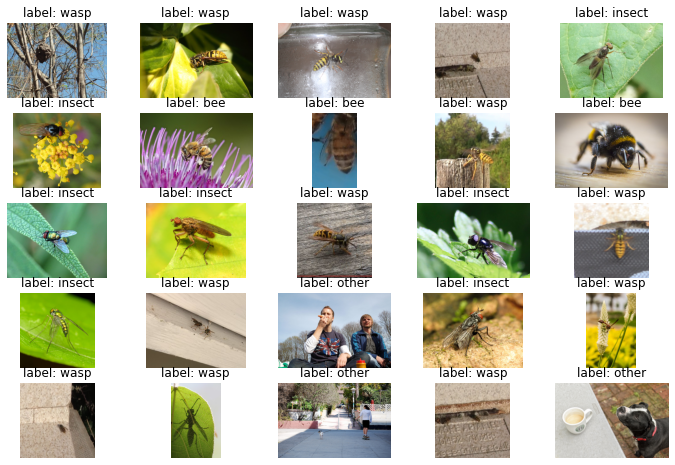

In [6]:
img_plot(df,25)

Defining learning rate scheduler and early stopping callbacks

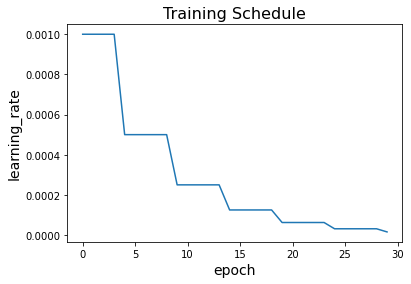

In [7]:
def get_lr_callback(batch_size = 16, plot=False):
    start_lr = 0.001
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 5.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(N_epochs)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               monitor='val_loss',
                                               verbose=1, 
                                               restore_best_weights=True)
lr = get_lr_callback(plot=True)

Define data generators

In [8]:
def gen_init(BS, IMG_Size):
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        vertical_flip = True,
        horizontal_flip=True)

    valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)    
    train_generator = train_gen.flow_from_dataframe(dataframe=df_train, directory=path, 
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

    valid_generator = valid_gen.flow_from_dataframe(dataframe=df_valid, directory=path, 
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  # class_mode="categorical", 
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

    test_generator = valid_gen.flow_from_dataframe(dataframe=df_test, directory=path, 
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  shuffle = False,
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)
    return   train_generator,   valid_generator, test_generator

In [9]:
train_generator, valid_generator, test_generator = gen_init(32,200)

Found 7939 validated image filenames.
Found 1719 validated image filenames.
Found 1763 validated image filenames.



Lets check the result of the train data generator preprocessing, just a single batch of images

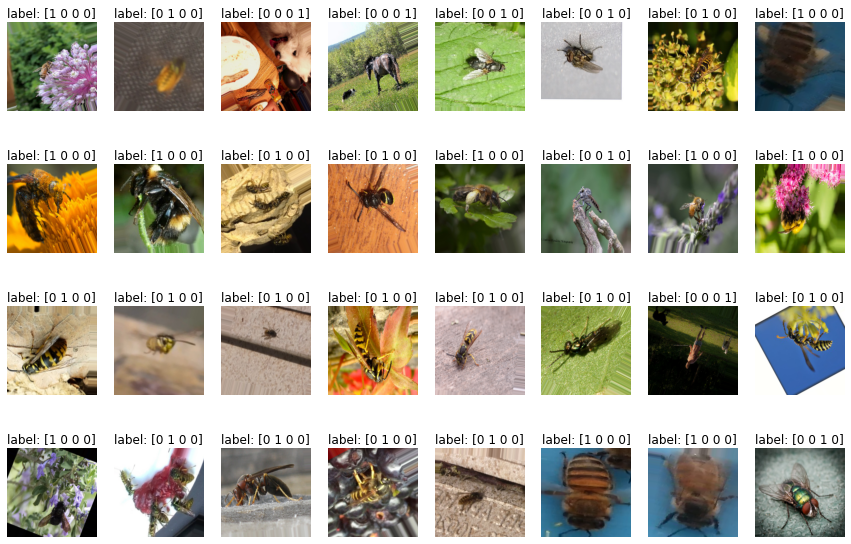

In [10]:
ti, tl = train_generator.next()
imgs = []
for i in range(ti.shape[0]):
    img = np.array(ti[i]*255, dtype = 'int32')
    imgs.append(img)

f, ax = plt.subplots(4, 8, figsize=(15,10))
for i, img in enumerate(imgs):
    ax[i//8, i%8].imshow(img)
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title('label: %s' % tl[i])
plt.show()

# Main part
Build a basic model template, so we can try a few different engines from the MODEL dictionary

In [11]:
def build_model(model_engine, IMG_Size):
    inp = tf.keras.layers.Input(shape=(IMG_Size,IMG_Size,3))
    base = model_engine(input_shape=(IMG_Size,IMG_Size,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(4,activation='softmax')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)   
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
all_model = []
all_history = []
all_preds = []
all_accuracies = []
all_confusion_matrices = []

Found 7939 validated image filenames.
Found 1719 validated image filenames.
Found 1763 validated image filenames.
94773248/94765736 [==============================] - 1s 0us/step
------------------------------------------------------------------
Training model  ResNet50
Epoch 1/30
249/248 [==============================] - 258s 1s/step - loss: 0.7994 - accuracy: 0.7141 - val_loss: 1.4702 - val_accuracy: 0.2077
Epoch 2/30
249/248 [==============================] - 243s 974ms/step - loss: 0.4496 - accuracy: 0.8363 - val_loss: 1.2718 - val_accuracy: 0.4596
Epoch 3/30
249/248 [==============================] - 248s 997ms/step - loss: 0.4284 - accuracy: 0.8466 - val_loss: 1.0119 - val_accuracy: 0.5800
Epoch 4/30
249/248 [==============================] - 239s 962ms/step - loss: 0.3676 - accuracy: 0.8626 - val_loss: 0.6963 - val_accuracy: 0.7452
Epoch 5/30
249/248 [==============================] - 242s 972ms/step - loss: 0.2684 - accuracy: 0.9043 - val_loss: 0.3099 - val_accuracy: 0.8901
Ep

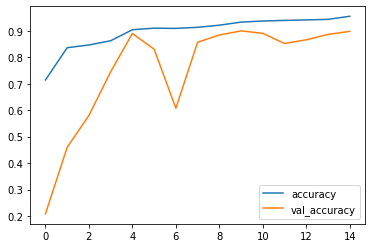

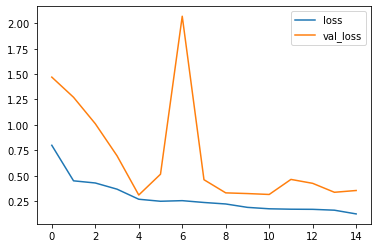

56/56 [==============================] - 15s 262ms/step
------------------------------------------------------------------
[[447  35  20   2]
 [ 20 659  55  19]
 [  8  27 337   4]
 [  0   4   1 125]]
0.8893930799773114
Found 7939 validated image filenames.
Found 1719 validated image filenames.
Found 1763 validated image filenames.
29089792/29084464 [==============================] - 0s 0us/step
------------------------------------------------------------------
Training model  DenseNet121
Epoch 1/30
249/248 [==============================] - 244s 980ms/step - loss: 0.5388 - accuracy: 0.8034 - val_loss: 2.2924 - val_accuracy: 0.6940
Epoch 2/30
249/248 [==============================] - 239s 960ms/step - loss: 0.3800 - accuracy: 0.8633 - val_loss: 3.2140 - val_accuracy: 0.5038
Epoch 3/30
249/248 [==============================] - 247s 991ms/step - loss: 0.3238 - accuracy: 0.8802 - val_loss: 0.7292 - val_accuracy: 0.8028
Epoch 4/30
249/248 [==============================] - 248s 996ms/step

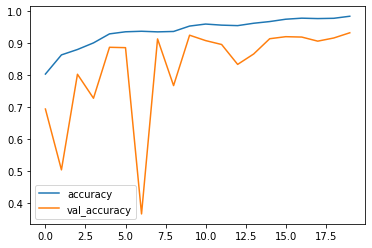

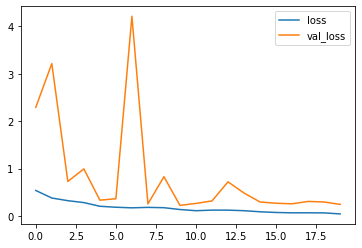

56/56 [==============================] - 11s 198ms/step
------------------------------------------------------------------
[[487   9   5   3]
 [ 17 697  18  21]
 [  8  28 331   9]
 [  0   2   1 127]]
0.9313669880884855
Found 7939 validated image filenames.
Found 1719 validated image filenames.
Found 1763 validated image filenames.
44113920/44107200 [==============================] - 1s 0us/step
------------------------------------------------------------------
Training model  EfficientNetB3
Epoch 1/30
993/992 [==============================] - 317s 319ms/step - loss: 0.5288 - accuracy: 0.8127 - val_loss: 0.4673 - val_accuracy: 0.8418
Epoch 2/30
993/992 [==============================] - 309s 311ms/step - loss: 0.3760 - accuracy: 0.8704 - val_loss: 0.3521 - val_accuracy: 0.8807
Epoch 3/30
993/992 [==============================] - 305s 307ms/step - loss: 0.3346 - accuracy: 0.8795 - val_loss: 1.0508 - val_accuracy: 0.8330
Epoch 4/30
993/992 [==============================] - 304s 306ms/s

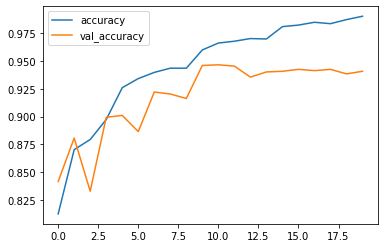

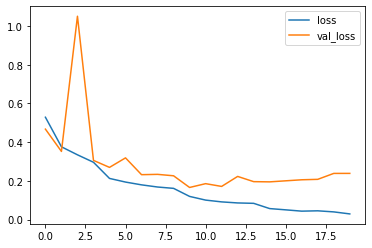

221/221 [==============================] - 18s 83ms/step
------------------------------------------------------------------
[[483  13   8   0]
 [ 13 702  18  20]
 [  6  19 345   6]
 [  0   3   1 126]]
0.9393079977311402
Found 7939 validated image filenames.
Found 1719 validated image filenames.
Found 1763 validated image filenames.
165527552/165527152 [==============================] - 2s 0us/step
------------------------------------------------------------------
Training model  EfficientNetB6
Epoch 1/30
993/992 [==============================] - 508s 511ms/step - loss: 0.5841 - accuracy: 0.7881 - val_loss: 0.3652 - val_accuracy: 0.8581
Epoch 2/30
993/992 [==============================] - 503s 507ms/step - loss: 0.3924 - accuracy: 0.8594 - val_loss: 0.3160 - val_accuracy: 0.8883
Epoch 3/30
993/992 [==============================] - 501s 505ms/step - loss: 0.3360 - accuracy: 0.8805 - val_loss: 0.2910 - val_accuracy: 0.8947
Epoch 4/30
993/992 [==============================] - 503s 507m

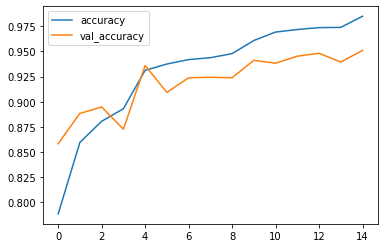

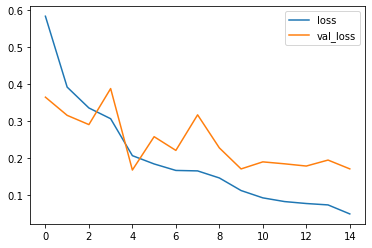

221/221 [==============================] - 21s 93ms/step
------------------------------------------------------------------
[[483  12   9   0]
 [ 16 705  27   5]
 [  5  23 347   1]
 [  0   5   0 125]]
0.9415768576290414


In [13]:
for model_name in MODELS:
    engine = MODELS[model_name][0]
    BS = MODELS[model_name][1]
    IMG_Size = MODELS[model_name][2]
    train_generator, valid_generator, test_generator = gen_init(BS, IMG_Size)
    
    model = build_model(engine, IMG_Size)
    print('------------------------------------------------------------------')
    print('Training model ', model_name)
    history = model.fit(train_generator,
              steps_per_epoch=len(df_train) / BS, epochs = N_epochs, verbose = 1,
              callbacks=[es_callback, get_lr_callback(BS)],
              validation_data = valid_generator)

    model.save('model-%s.h5'%model_name)  
    all_history.append(history)
    
    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.show()

    preds = model.predict(test_generator, verbose = 1)
    all_preds.append(preds)
    cm = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(preds, axis = 1))
    all_confusion_matrices.append(cm)
    acc = accuracy_score(np.argmax(np.array(y_test), axis=1), np.argmax(preds, axis = 1))    
    all_accuracies.append(acc)
    print('------------------------------------------------------------------')
    print(cm)
    print(acc)
    

# Analysis
Lets have a look at all of the confusion matrices

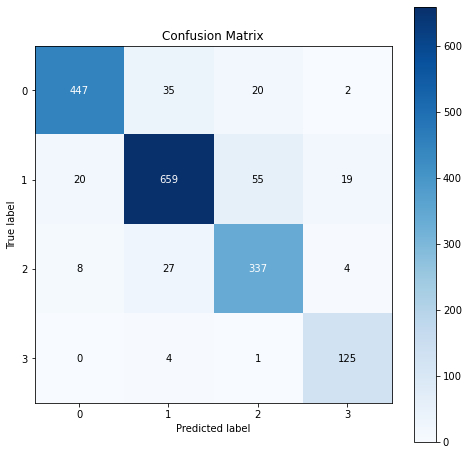

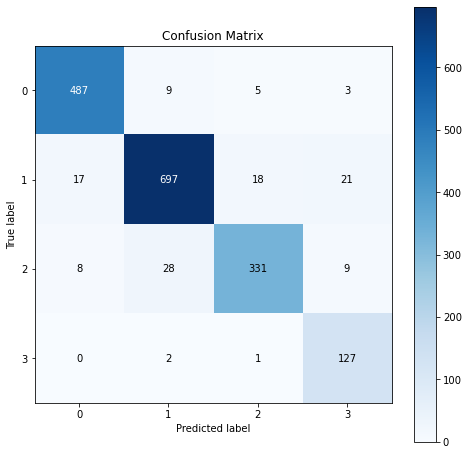

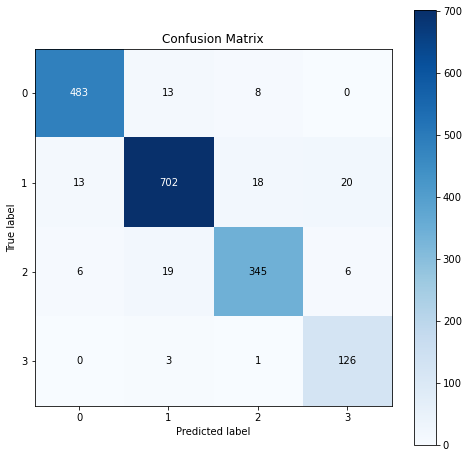

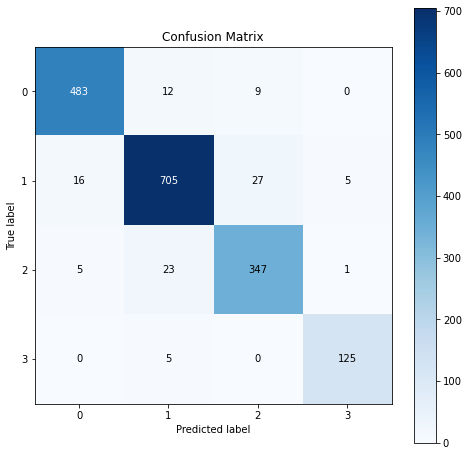

In [14]:
for i, model_name in enumerate(MODELS):
    skplt.metrics.plot_confusion_matrix(
        np.argmax(np.array(y_test), axis=1), np.argmax(all_preds[i], axis = 1),
        figsize=(8,8))

And now for an alternative view here all these matrices are normalized.

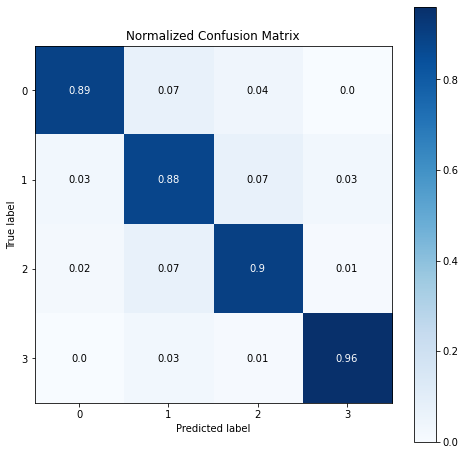

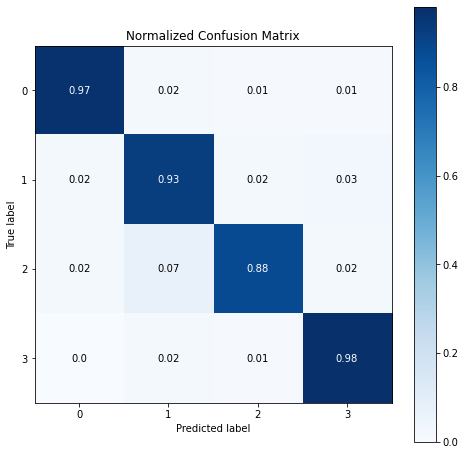

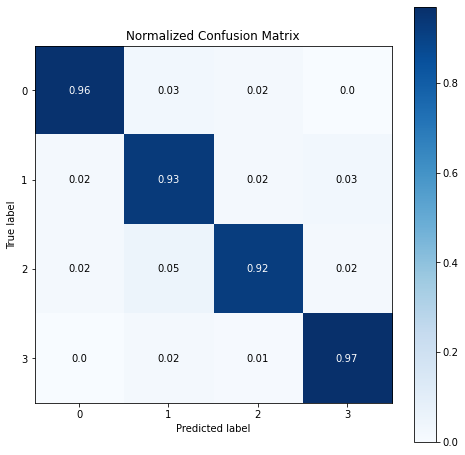

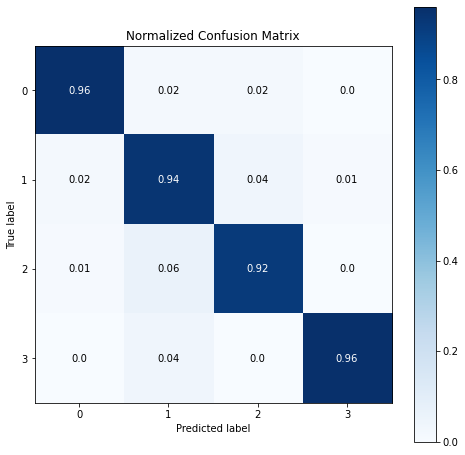

In [15]:
for i, model_name in enumerate(MODELS):
    skplt.metrics.plot_confusion_matrix(
        np.argmax(np.array(y_test), axis=1), np.argmax(all_preds[i], axis = 1), normalize=True,
        figsize=(8,8))

In [16]:
print(all_accuracies)

[0.8893930799773114, 0.9313669880884855, 0.9393079977311402, 0.9415768576290414]


Looks like EfficientNetB6 is winning with all other parameters set similarly for all models. Although EfficientNetB3 performs well too.
Lets analyze what will happen when we add some flowers/blossom without any insects, to find out if the model simply recognizes flowers or bees in fact (Task 2 that George Rey defined for the dataset).
We'll add the new images to the test set only.

In [17]:
def gen_test_init(df, BS, IMG_Size):
    tta_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        vertical_flip = True,
        horizontal_flip=True)

    valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)    

    test_generator = valid_gen.flow_from_dataframe(dataframe=df, directory=path, 
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  shuffle = False,
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)
    tta_test_generator = tta_gen.flow_from_dataframe(dataframe=df, directory=path, 
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  shuffle = False,
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)
    return  tta_test_generator, test_generator

We will also test if **Test Time Augmentation** (TTA) will help in this case

In [18]:
all_preds_tta = []
all_accuracies_tta = []
all_confusion_matrices_tta = []

model_name = 'EfficientNetB6'
engine = MODELS[model_name][0]
BS = MODELS[model_name][1]
IMG_Size = MODELS[model_name][2]
tta_test_generator, test_generator = gen_test_init(df_test, BS, IMG_Size)

model = tf.keras.models.load_model('model-%s.h5'%model_name)
print('Predicting original images', model_name)

preds_org = model.predict(test_generator, verbose = 1)
all_preds_tta.append(preds_org)
cm_org = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(preds_org, axis = 1))
all_confusion_matrices_tta.append(cm_org)
acc_org = accuracy_score(np.argmax(np.array(y_test), axis=1), np.argmax(preds_org, axis = 1))    
all_accuracies_tta.append(acc_org)
print(cm_org)
print(acc_org)

for i in range(N_TTA):
    print('Predicting images TTA %i for %s'%(i, model_name))

    preds_tta = model.predict(tta_test_generator, verbose = 1)
    all_preds_tta.append(preds_tta)
    cm_tta = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(preds_tta, axis = 1))
    all_confusion_matrices_tta.append(cm_tta)
    acc_org = accuracy_score(np.argmax(np.array(y_test), axis=1), np.argmax(preds_tta, axis = 1))    
    all_accuracies_tta.append(acc_org)
    print(cm_tta)
    print(acc_org)

avg_preds = np.mean(np.array(all_preds_tta),axis = 0)
cm_tta = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(avg_preds, axis = 1))
all_confusion_matrices_tta.append(cm_tta)
acc_org = accuracy_score(np.argmax(np.array(y_test), axis=1), np.argmax(avg_preds, axis = 1))    
all_accuracies_tta.append(acc_org)
print('Confusion matrix with %i TTA : '%N_TTA)
print(cm_tta)
print('Prediction with TTA - averaged accuracy %.4f' %acc_org) 


Found 1763 validated image filenames.
Found 1763 validated image filenames.
Predicting original images EfficientNetB6
221/221 [==============================] - 20s 92ms/step
[[483  12   9   0]
 [ 16 705  27   5]
 [  5  23 347   1]
 [  0   5   0 125]]
0.9415768576290414
Predicting images TTA 0 for EfficientNetB6
221/221 [==============================] - 47s 214ms/step
[[490   7   7   0]
 [ 24 694  32   3]
 [  4  26 346   0]
 [  0  10   0 120]]
0.9359047078842881
Predicting images TTA 1 for EfficientNetB6
221/221 [==============================] - 47s 212ms/step
[[494   4   6   0]
 [ 24 706  22   1]
 [  6  28 342   0]
 [  0   9   1 120]]
0.942711287577992
Predicting images TTA 2 for EfficientNetB6
221/221 [==============================] - 47s 212ms/step
[[488   9   7   0]
 [ 22 702  29   0]
 [  4  29 343   0]
 [  1   9   1 119]]
0.9370391378332388
Predicting images TTA 3 for EfficientNetB6
221/221 [==============================] - 46s 210ms/step
[[491   8   5   0]
 [ 25 700  27   1]


And we see that we get a significant boost from the **TTA** . <br>
Now lets check what happens when we add images of flowers without bees from mine dataset to the test set

In [19]:
all_preds_tta = []
all_accuracies_tta = []
all_confusion_matrices_tta = []

tta_test_generator, test_generator = gen_test_init(df_test_ext, BS, IMG_Size)
print('Predicting original images', model_name)

preds_org = model.predict(test_generator, verbose = 1)
all_preds_tta.append(preds_org)
cm_org = confusion_matrix(np.argmax(np.array(y_test_ext), axis=1), np.argmax(preds_org, axis = 1))
all_confusion_matrices_tta.append(cm_org)
acc_org = accuracy_score(np.argmax(np.array(y_test_ext), axis=1), np.argmax(preds_org, axis = 1))    
all_accuracies_tta.append(acc_org)
print(cm_org)
print(acc_org)

for i in range(N_TTA):
    print('Predicting augmented images batch %i for %s'%(i+1, model_name))

    preds_tta = model.predict(tta_test_generator, verbose = 1)
    all_preds_tta.append(preds_tta)
    cm_tta = confusion_matrix(np.argmax(np.array(y_test_ext), axis=1), np.argmax(preds_tta, axis = 1))
    all_confusion_matrices_tta.append(cm_tta)
    acc_org = accuracy_score(np.argmax(np.array(y_test_ext), axis=1), np.argmax(preds_tta, axis = 1))    
    all_accuracies_tta.append(acc_org)
    print(cm_tta)
    print(acc_org)

avg_preds = np.mean(np.array(all_preds_tta),axis = 0)
cm_tta = confusion_matrix(np.argmax(np.array(y_test_ext), axis=1), np.argmax(avg_preds, axis = 1))
all_confusion_matrices_tta.append(cm_tta)
acc_org = accuracy_score(np.argmax(np.array(y_test_ext), axis=1), np.argmax(avg_preds, axis = 1))    
all_accuracies_tta.append(acc_org)
print('Confusion matrix with %i TTA : '%N_TTA)
print(cm_tta)
print('Prediction with TTA - averaged accuracy %.4f' %acc_org) 

Found 2133 validated image filenames.
Found 2133 validated image filenames.
Predicting original images EfficientNetB6
267/267 [==============================] - 27s 100ms/step
[[483  12   9   0]
 [ 16 705  27   5]
 [  5  23 347   1]
 [ 31 260   3 206]]
0.816221284575715
Predicting augmented images batch 1 for EfficientNetB6
267/267 [==============================] - 59s 221ms/step
[[490   6   8   0]
 [ 24 703  26   0]
 [  5  24 347   0]
 [ 48 282   7 163]]
0.7984060009376465
Predicting augmented images batch 2 for EfficientNetB6
267/267 [==============================] - 58s 219ms/step
[[490   7   7   0]
 [ 21 701  31   0]
 [  5  26 345   0]
 [ 45 281   6 168]]
0.7988748241912799
Predicting augmented images batch 3 for EfficientNetB6
267/267 [==============================] - 59s 219ms/step
[[491   7   6   0]
 [ 23 706  22   2]
 [  6  25 345   0]
 [ 50 279   3 168]]
0.8016877637130801
Predicting augmented images batch 4 for EfficientNetB6
267/267 [==============================] - 69s 

And here we clearly see that unfortunately our model learnt to recognize flowers/blossom for both bees and wasps. And surprisingly the problem is more severe with images of wasps than bees. <br> We shall have more such images in our data set, and include them in the training set to cope with the issue.

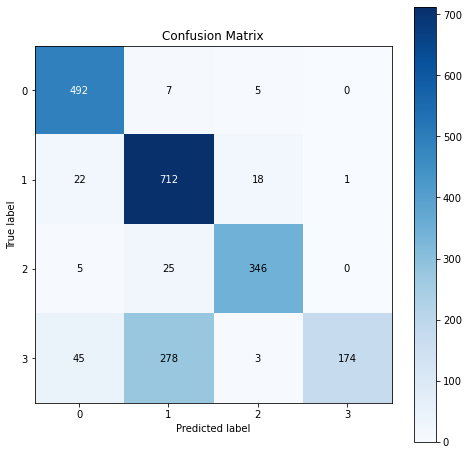

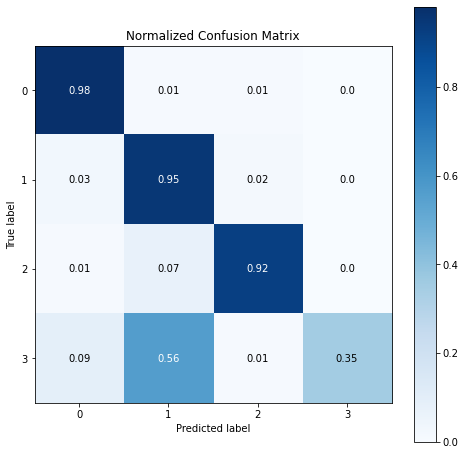

In [20]:
skplt.metrics.plot_confusion_matrix(
        np.argmax(np.array(y_test_ext), axis=1), np.argmax(avg_preds, axis = 1), normalize=False,
        figsize=(8,8))
skplt.metrics.plot_confusion_matrix(
        np.argmax(np.array(y_test_ext), axis=1), np.argmax(avg_preds, axis = 1), normalize=True,
        figsize=(8,8))